## <span style="color: Navy"> Table des matières </span> 
##### 1.[Introduction](#.-Introduction)

##### 2.[Collecte des données](#.-Collecte_des_données)

##### 3.[Prétraitement](#.-Prétraitement)

##### 4.[Construction du modèle](#.-Construction_du_modèle)

##### 5.[Evaluation du modèle ](#.-Evaluation_du_modèle)



## <p style='text-align: center;'> Analyse des sentiments Tweets 😀 😢 </p> 

## <span style="color: Navy"> 1.Intorduction </span> 

<div style="text-align:center;">
<img src="images/Le flux de travail général de l'analyse des sentiments.png" alt="Analyse des sentiments: Processus" width="400" height="200">
</div>

***

 ## <span style="color:Navy"> 2. Collecte des données </span>

****

<span style="color: DimGray"> **1.1 Importation des bibliothèques**  </span>

In [1]:
import pandas as pd 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score,recall_score,f1_score
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from keras.layers import LSTM, Embedding, Dense, Dropout
from nltk.tokenize import word_tokenize
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer


<span Style="color: DimGray"> **1.2 Importation des données**</span> 

In [2]:
colonnes= ['ids', 'Target', 'text']
df1 = pd.read_csv('datasets\Sentiment140-MV-Train.csv',names=colonnes)
df2=pd.read_csv('datasets\Sentiment140-MV-Test.csv',names=colonnes)
df = pd.concat([df1, df2], ignore_index=True)

In [3]:
df.head()

,ids,Target,text
0,1834873030,1,USER_MENTION oh that sounds yummy we dont have...
1,2062647136,0,USER_MENTION theres so many fakes of you
2,2013029024,1,USER_MENTION um nothing new apart from street ...
3,2184368404,1,USER_MENTION USER_MENTION the day cnn started ...
4,2214865531,0,missing my dad my brother today


<span style="color:DimGray"> **1.3 exploration des données**</span>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19995 entries, 0 to 19994
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ids     19995 non-null  int64 
 1   Target  19995 non-null  int64 
 2   text    19995 non-null  object
dtypes: int64(2), object(1)
memory usage: 468.8+ KB


In [5]:
df.isnull().sum()

ids       0
Target    0
text      0
dtype: int64

In [6]:
df.duplicated().sum()

1782

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df['Target'].value_counts()

Target
1    11628
0     6585
Name: count, dtype: int64

## <span style="color:Navy"> 3. Prétraitement</span>

***

<span style="color:DimGray"> **3.1 Suppression des colonnes non-utiles** </span>

 <span style="color: DimGray"> **3.2 Covertion de Target 4 à 1**  </span> 

<span style="color: DimGray"> **3.3 Visualisation des données ( La distribution des classes)** </span> 

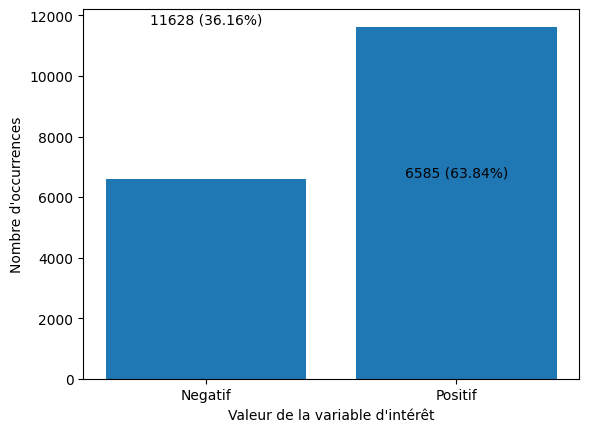

In [9]:
target_counts = df['Target'].value_counts()

# Calcul du proportion pour chaque valeur de la variable d'intérêt (Target)
target_proportions = df['Target'].value_counts(normalize=True)

# Création d'un graphique à barres pour visualiser la distribution
plt.bar(target_counts.index, target_counts.values)

# Ajoute des étiquettes des barres (nombre d'occurrences et proportion)
for i, count in enumerate(target_counts):
    proportion = target_proportions[i]
    plt.text(i, count, f"{count} ({proportion:.2%})", ha='center', va='bottom')

# Étiquetage de l'axe des x et y
plt.xlabel('Valeur de la variable d\'intérêt')
plt.ylabel('Nombre d\'occurrences')

# Ajoute d'une légende aux barres
plt.xticks(target_counts.index, ['Positif', 'Negatif'])

# Affichage du graphique
plt.show()

<span style="color:DimGray"> **3.4 Racinisation** </span> 

In [10]:
import re 
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [11]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [13]:
def lemmitizer(content):
    # Suppression des caractères non alphabétiques
    texte_nettoye = re.sub('[^a-zA-Z]', ' ', content)
    # Suppression des adresses URL
    content = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))', ' ', content)
    content = content.lower()
    # Tokenization
    tokens = content.split()
    # Lemmatisation et suppression des mots vides
    lemmitized_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    # Reconstruction du texte
    lemmitized_text = ' '.join(lemmitized_tokens)
    return lemmitized_text


# On applique le nettoyage du texte sur la colonne 'texte'
df['texte_nettoye'] = df['text'].apply(lemmitizer)

In [14]:
df.head()

,ids,Target,text,texte_nettoye
0,1834873030,1,USER_MENTION oh that sounds yummy we dont have...,user_mention sound yummy dont bloomingdales th...
1,2062647136,0,USER_MENTION theres so many fakes of you,user_mention there many fake
2,2013029024,1,USER_MENTION um nothing new apart from street ...,user_mention nothing new apart street fighter
3,2184368404,1,USER_MENTION USER_MENTION the day cnn started ...,user_mention user_mention day cnn started sour...
4,2214865531,0,missing my dad my brother today,missing dad brother today


<span style='color:DimGray'> **3.5 Visualisation** </spand>

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 

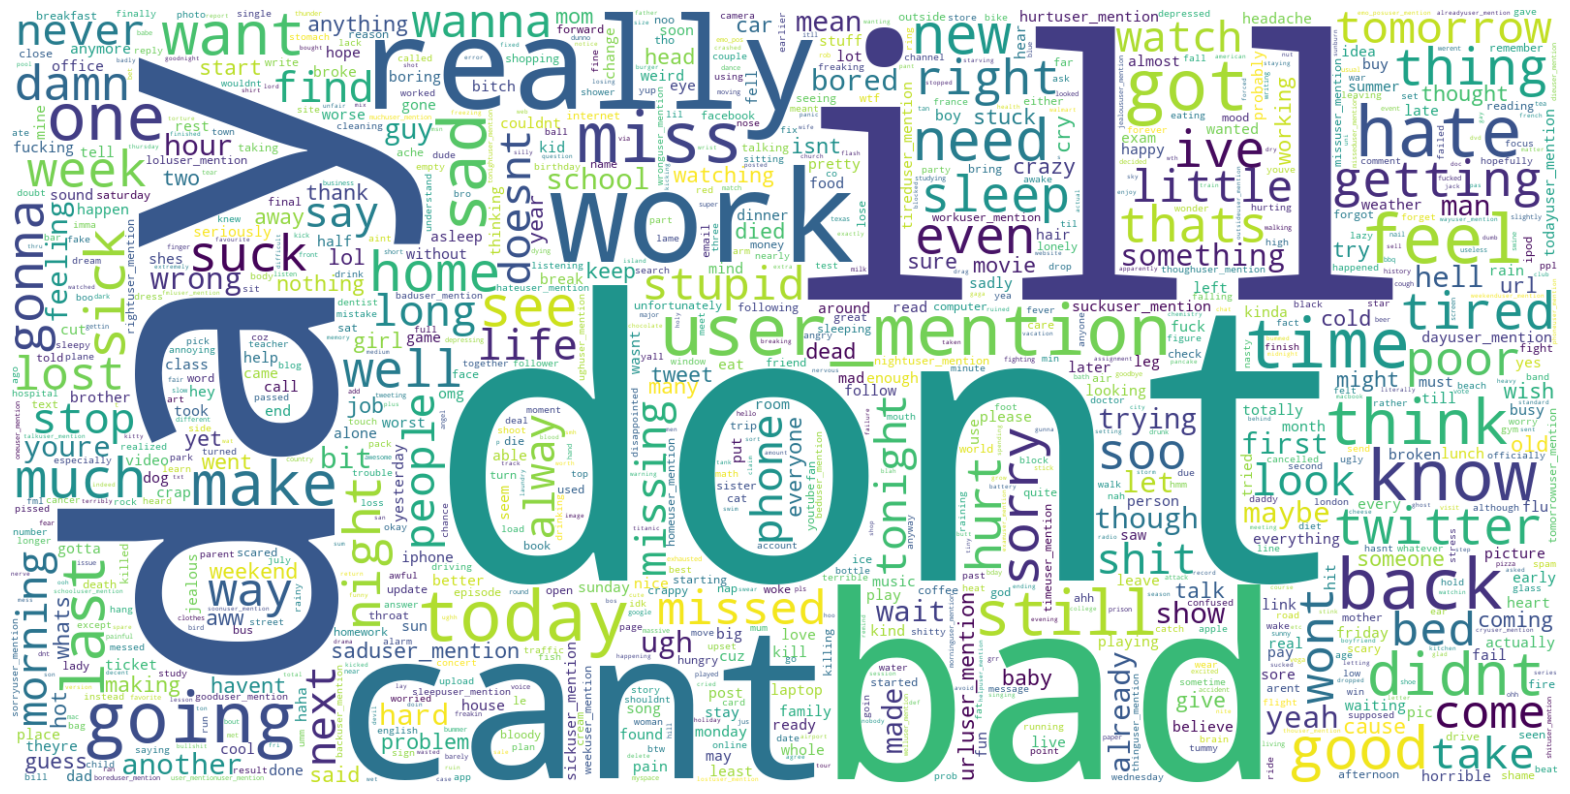

In [16]:
#filtrage des tweets Negatif 
data_neg= df[df['Target'] == 0]['texte_nettoye']

#Création d'un nuage de mots  
wc = WordCloud(max_words = 1000, width=1600, height = 800, collocations= False, background_color='white').generate("".join(data_neg))

#affichage 
plt.figure(figsize=(20, 20))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

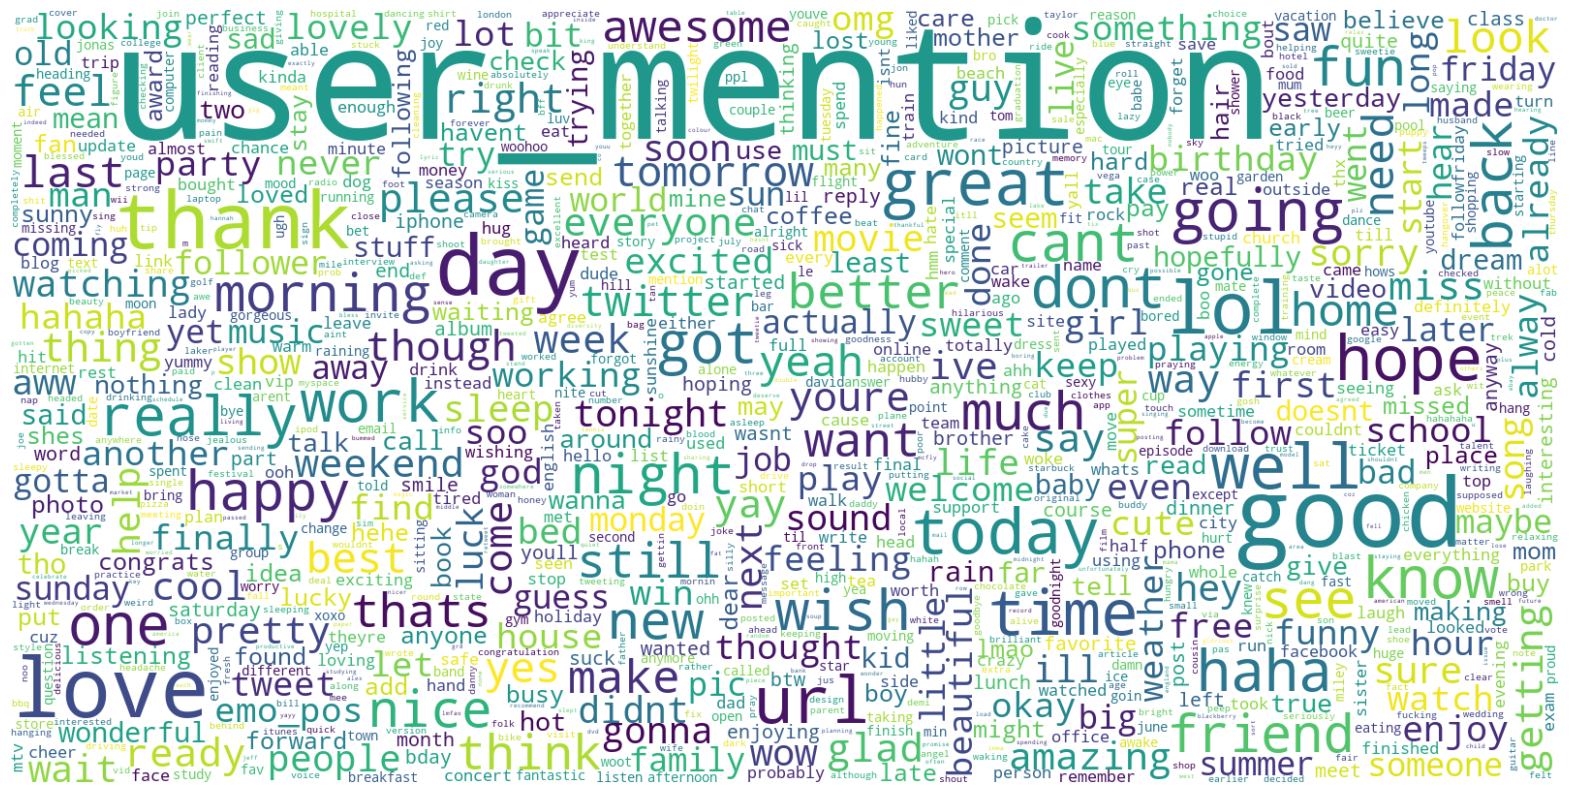

In [17]:
#filtrage des tweets posifit
data_neg = df[df['Target'] == 1]['texte_nettoye']

# Créer un nuage de mots à partir des données négatives
wc = WordCloud(max_words=1000, width=1600, height=800, collocations=False, background_color='white').generate(" ".join(data_neg))

# Afficher le nuage de mots
plt.figure(figsize=(20, 20))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

<span style='color:DimGray'> **3.6 Modélisation** </spand>

* Séparation des données

In [18]:
X=df['texte_nettoye'].values
Y=df['Target'].values

**X:** Représente la variable indépendante

**Y:** Représente la variable dépendante

In [19]:
# Division du dataset en ensembles d'entraînement, de validation et de test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42) 

<span style='color:DimGray'> **3.7 Convertion du texte en numérique** </spand>

In [20]:
# Création du vocabulaire et conversion des textes en séquences de nombres
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

 ## <span style='color:Navy'> 4.Construction du modèle </span>

****

<span style='color:DimGray'>  **Construction du modèle** </span> 

In [21]:
# Conversion des textes en séquences de nombres et remplissage des séquences pour avoir la même longueur
maxlen = 100  # Longueur maximale des séquences
X_train_sequences = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=maxlen)
X_val_sequences = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=maxlen)
X_test_sequences = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=maxlen)

In [22]:


vocab_size = len(tokenizer.word_index) + 1
# Création du modèle RNN
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))  

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [23]:
# Entraînement du modèle et enregistrement de l'historique
history = model.fit(X_train_sequences, y_train, batch_size=64, epochs=5, validation_data=(X_val_sequences, y_val))

Epoch 1/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 35s 146ms/step - accuracy: 0.7087 - loss: 0.5521 - val_accuracy: 0.8726 - val_loss: 0.3307
Epoch 2/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 29s 140ms/step - accuracy: 0.9267 - loss: 0.2179 - val_accuracy: 0.8683 - val_loss: 0.3564
Epoch 3/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 26s 126ms/step - accuracy: 0.9449 - loss: 0.1616 - val_accuracy: 0.8601 - val_loss: 0.3739
Epoch 4/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 31s 152ms/step - accuracy: 0.9679 - loss: 0.1013 - val_accuracy: 0.8463 - val_loss: 0.4518
Epoch 5/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 48s 188ms/step - accuracy: 0.9736 - loss: 0.0859 - val_accuracy: 0.8472 - val_loss: 0.5072


## <span style='color:Navy'> 5.Evaluation du modèle </span>

****

<span style='color:DimGray'> **5.1 Accuracy et précision** </span>

* Accuracy

In [27]:
# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test_sequences)
y_pred = y_pred.argmax(axis=-1)

86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step


* Précision

In [28]:
accuracy = accuracy_score(y_test, y_pred)
print("accuracy :", accuracy)

accuracy : 0.8524890190336749


In [29]:
# Calcul de la précision
precision = precision_score(y_test, y_pred, average='weighted')
print("prescision:", precision)


prescision: 0.851224068250157


In [30]:
# Calcul du score F1
f1 = f1_score(y_test, y_pred, average='weighted')
print("Score F1 (F1 score) :", f1)

Score F1 (F1 score) : 0.850827767330573


In [31]:

recall = recall_score(y_test, y_pred, average='weighted')
print("Score F1 (F1 score) :", recall)

Score F1 (F1 score) : 0.8524890190336749


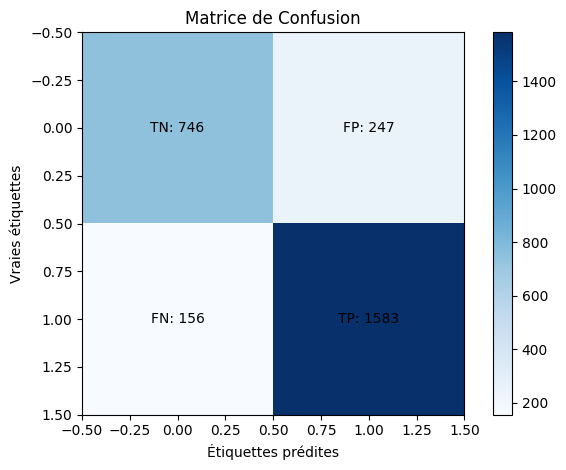

In [36]:
import itertools
import matplotlib.pyplot as plt
import numpy as np

# Créer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Calculer les indicateurs de performance
tn, fp, fn, tp = cm.ravel()

# Afficher la matrice de confusion avec les indicateurs de performance
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)  # Utiliser le colormap Blues pour différentes nuances de bleu
plt.title('Matrice de Confusion')
plt.colorbar()




# Ajouter les indicateurs de performance
plt.text(0, 0, f'TN: {tn}', ha='center', va='center', color='black')
plt.text(1, 0, f'FP: {fp}', ha='center', va='center', color='black')
plt.text(0, 1, f'FN: {fn}', ha='center', va='center', color='black')
plt.text(1, 1, f'TP: {tp}', ha='center', va='center', color='black')

plt.ylabel('Vraies étiquettes')
plt.xlabel('Étiquettes prédites')
plt.tight_layout()
plt.show()

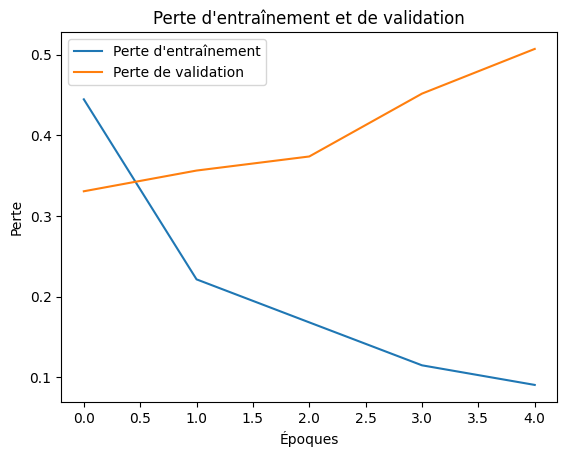

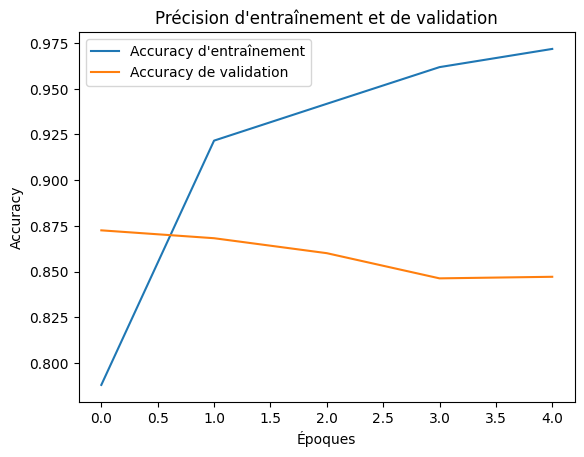

In [38]:
# Extraire les données d'historique
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot loss
plt.plot(train_loss, label='Perte d\'entraînement')
plt.plot(val_loss, label='Perte de validation')
plt.title('Perte d\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(train_accuracy, label='Accuracy d\'entraînement')
plt.plot(val_accuracy, label='Accuracy de validation')
plt.title('Précision d\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
